### 1. Load packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
import WEST_plt

import random, torch
import SpaGCN as spg

2024-10-14 15:50:04.316187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 15:50:04.487923: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 15:50:05.518324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-14 15:50:05.518447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 2. Load data

In [2]:
#### Read data from pickle
with open('../data/raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. Preprocess

In [20]:
%%capture captured_output
adj = spg.pairwise_distance(adata.obs[['loc_x', 'loc_y']].to_numpy().astype(np.float32))
p=0.6; 
r_seed=t_seed=n_seed=1234
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

# preprocess
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

### 4. Model training

In [21]:
# parameter tuning
l = spg.search_l(p, adj, start=0.1, end=1000, tol=0.01, max_run=100)
n_clusters = len(adata.obs['true cluster'].unique())
res = spg.search_res(adata, adj, l, target_num=7, start=0.1, step=0.1, tol=5e-3, lr=0.05, max_epochs=200, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

# train
clf = spg.SpaGCN()
clf.set_l(l)
clf.train(adata ,adj, num_pcs=50, init_spa=True, init='louvain', res=res, tol=5e-3, lr=0.05, max_epochs=500)
y_pred, prob = clf.predict()
adata.obs['SpaGCN']= y_pred

# get new embedding
z,q = clf.model.predict(clf.embed,clf.adj_exp)
SpaGCN_embedding = z.detach().numpy()
adata.obsm['SpaGCN'] = SpaGCN_embedding

Run 1: l [0.1, 1000], p [0.0, 4127.877157957879]
Run 2: l [0.1, 500.05], p [0.0, 3858.35009765625]
Run 3: l [0.1, 250.07500000000002], p [0.0, 3034.930908203125]
Run 4: l [0.1, 125.0875], p [0.0, 1593.5272216796875]
Run 5: l [0.1, 62.59375], p [0.0, 556.06103515625]
Run 6: l [0.1, 31.346875], p [0.0, 160.509765625]
Run 7: l [0.1, 15.723437500000001], p [0.0, 42.4669303894043]
Run 8: l [0.1, 7.91171875], p [0.0, 10.372659683227539]
Run 9: l [0.1, 4.005859375], p [0.0, 1.9688982963562012]
Run 10: l [2.0529296875, 4.005859375], p [0.06039714813232422, 1.9688982963562012]
Run 11: l [2.0529296875, 3.02939453125], p [0.06039714813232422, 0.7287068367004395]
Run 12: l [2.5411621093749996, 3.02939453125], p [0.2966541051864624, 0.7287068367004395]
Run 13: l [2.7852783203125, 3.02939453125], p [0.49166083335876465, 0.7287068367004395]
recommended l =  2.90733642578125
Start at res =  0.1 step =  0.1
Initializing cluster centers with louvain, resolution =  0.1
Epoch  0
Epoch  10
delta_label  0.0

### 4. Clustering

In [22]:
ARI = adjusted_rand_score(adata.obs['SpaGCN'], adata.obs['true cluster']) 
print('ARI: ', ARI)
print(adata.obs['SpaGCN'].unique())

ARI:  0.4486460327603472
[2 1 6 0 5 4 7 3]


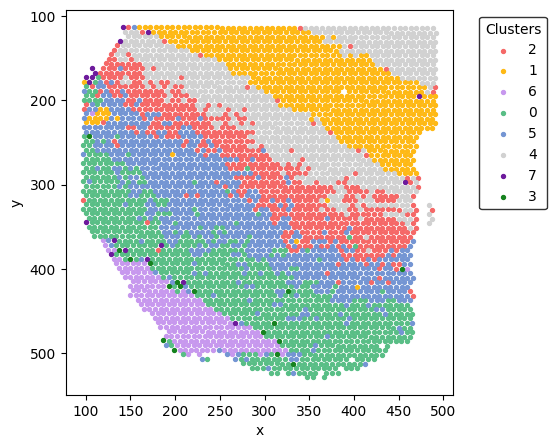

In [23]:
WEST_plt.WEST_scatter(adata, reps='SpaGCN', switch_coordinate=True, invert_y=True, s=8)

### 5. Save embedding

In [24]:
np.savetxt('../embedding/SpaGCN_embedding.csv',SpaGCN_embedding, delimiter=',')
np.savetxt('../embedding/SpaGCN_cluster.csv', adata.obs['SpaGCN'], delimiter=',', fmt='%s')